## NYC Taxi Duration Prediction
In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.



### Data Exploration


Import necessary libraries.

In [9]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Import Data

In [10]:
start = time.time()
train_df = pd.read_csv('./data/train.csv')
end = time.time()
print("Time taken by above cell is {}".format((end-start)))
train_df.head()

Time taken by above cell is 3.0806379318237305


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [11]:
# checking if Ids are unique, 
train_data = train_df.copy()
start = time.time()
print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print("Train ids are unique")
print("Number of Nulls: {}.".format(train_data.isnull().sum().sum()))
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Number of columns and rows and columns are 11 and 1458644 respectively.
Train ids are unique
Number of Nulls: 0.
Time taken by above cell is 0.6266920566558838.


### Lets visualize the trip duration given using log-scale distplot in sns
We are asked to predict trip_duration of the test set, so we first check what kind of trips durations are present in the dataset. First I plotted it on a plain scale and not on a log scale, and some of the records have very long trip durations ~100 hours. Such long trips are making all another trip invisible in the histogram on plain scale => We go ahead with the log scale. Another reason of using the log scale for visualizing trip-duration on the log scale is that this competition uses rmsle matrix so it would make sense to visualize the target variable in log scale only.

Time taken by above cell is 0.5448830127716064.


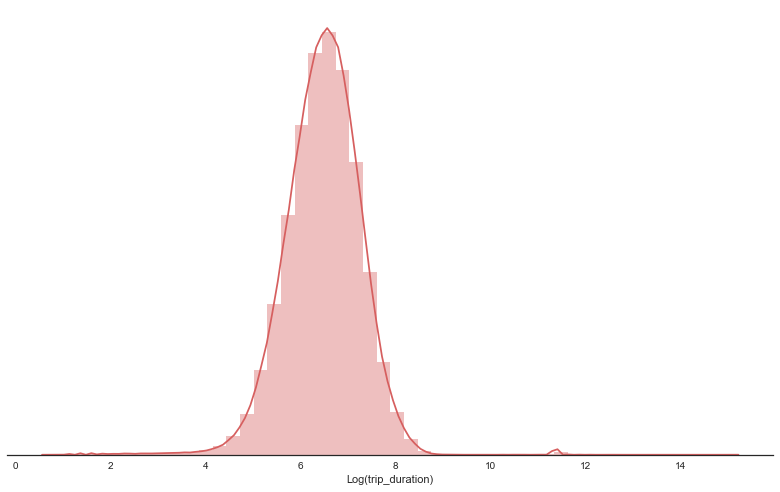

In [12]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

This shows that the trip durations are an approximate Gaussian distribution. Despite some outlier trips, most trips are e^4 = 1 minute to e^8 ~ 60 minutes.

### Heatmap for Pickup and Dropoff Locations
Each location is represented by a latitude and longitude, we can plot these points on a map.


### Model Selection